## XBoosting Modelling

### Import relevant libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier

from joblib import dump, load

In [2]:
df = pd.read_csv('weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [3]:
#We will also define a function to display the confusion matrix and classification_report
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix
    conf_matrix = confusion_matrix(test, pred_test)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### Xboosting

### 1. Without Over and Undersampling

In [4]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1 Default Xboosting model

In [5]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

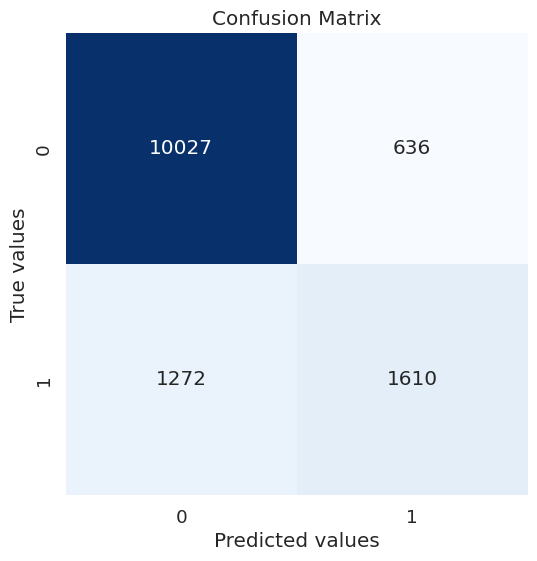

-------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     10663
         1.0       0.72      0.56      0.63      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.75      0.77     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Accuracy Train Set: 0.91 Accuracy Test Set: 0.859


In [6]:
y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train)

### 2. Undersampling

**2.1 Random Undersampling**

In [7]:
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Define the XGBoost classifier
xgb = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.1)

# Fit the model using the undersampled data
xgb_rus = xgb.fit(x_train_undersampled, y_train_undersampled)

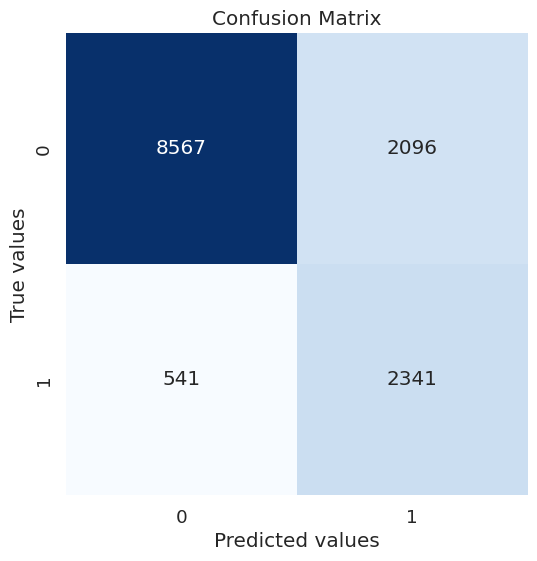

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87     10663
         1.0       0.53      0.81      0.64      2882

    accuracy                           0.81     13545
   macro avg       0.73      0.81      0.75     13545
weighted avg       0.85      0.81      0.82     13545

-------------------------
Accuracy Train Set: 0.866 Accuracy Test Set: 0.805


In [8]:
y_pred_rus = xgb_rus.predict(X_test)
y_pred_train_rus = xgb_rus.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_rus, y_train, y_pred_train_rus)

### 3. Random Undersampling Hyperparameter Tuning

### 3.1 GridSearchCV

In [9]:
param_grid = {
    'n_estimators': [300],  # Number of trees in the forest
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='precision')
xgb_rus_grid = grid_search.fit(x_train_undersampled, y_train_undersampled)

In [10]:
dump(xgb_rus_grid, 'xgb_rus_grid.joblib')

['xgb_rus_grid.joblib']

In [11]:
xgb_rus_grid = load('xgb_rus_grid.joblib')
xgb_rus_grid .best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

### 3.2 Best Parameter Fit

In [12]:
xgb = XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 300)
xgb_rus_best = xgb.fit(x_train_undersampled,y_train_undersampled)

In [13]:
dump(xgb_rus_best, 'xgb_rus_best.joblib')

['xgb_rus_best.joblib']

In [14]:
xgb_rus_best = load('xgb_rus_best.joblib')

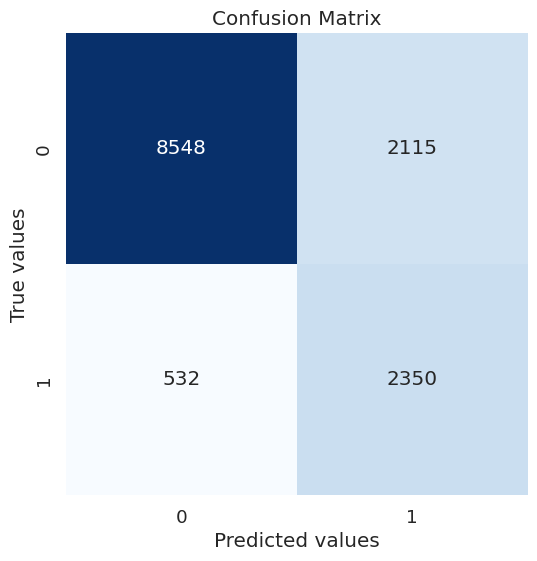

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87     10663
         1.0       0.53      0.82      0.64      2882

    accuracy                           0.80     13545
   macro avg       0.73      0.81      0.75     13545
weighted avg       0.85      0.80      0.82     13545

-------------------------
Accuracy Train Set: 0.833 Accuracy Test Set: 0.805


In [15]:
y_pred_rus_best = xgb_rus_best.predict(X_test)
y_pred_train_rus_best = xgb_rus_best.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_rus_best, y_train, y_pred_train_rus_best)

### 4. Location-based analysis

In [16]:
def location_scores(sampler, classifier):
    locations = df.Location.unique()
    region_models = {}
    results = []

    for location in locations:
        region_data = df[df['Location'] == location]
        X_loc = region_data.drop(['RainTomorrow', 'Location', 'Date'], axis=1)
        y_loc = region_data['RainTomorrow']
        X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X_loc, y_loc, test_size=0.2, random_state=42)

        X_loc_ros,y_loc_ros = sampler.fit_resample(X_train_loc,y_train_loc)

        #Train Classifier for each region
        classifier.fit(X_loc_ros,  y_loc_ros)
        region_models[location] = classifier

        #Score for each region
        y_pred_loc = classifier.predict(X_test_loc)
        accuracy = accuracy_score(y_test_loc, y_pred_loc)
        precision = precision_score(y_test_loc, y_pred_loc)
        recall = recall_score(y_test_loc, y_pred_loc)
        f1 = f1_score(y_test_loc, y_pred_loc)

        results.append({
            'Location': location,
            'Accuracy': round(accuracy, 2),
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1': round(f1, 2)
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [17]:
location_scores(undersampler, xgb_rus_best)

,Location,Accuracy,Precision,Recall,F1
0,Cobar,0.86,0.49,0.81,0.61
1,CoffsHarbour,0.79,0.62,0.72,0.66
2,Moree,0.85,0.44,0.89,0.59
3,NorfolkIsland,0.71,0.53,0.69,0.60
4,SydneyAirport,0.75,0.50,0.79,0.61
5,WaggaWagga,0.83,0.53,0.85,0.65
6,Williamtown,0.78,0.52,0.84,0.64
7,Canberra,0.77,0.43,0.81,0.56
8,Sale,0.75,0.45,0.81,0.58
9,MelbourneAirport,0.73,0.41,0.86,0.56


### 8. Conclusion